## Resonance Alignment for a single Microring resonator using defect-mediated photo-detection

Author: Simon Bélanger-de Villers

Date: 13/12/2018

Based on H. Jayatilleka<s paper Wavelength tuning and stabilization of
microring-based filters using silicon
in-resonator photoconductive heaters  DOI:10.1364/OE.23.025084

## 1) Microring Resonator class

Define a microring object to control the setup.

In [1]:
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np
import time

class MRM(object):
    """ Class for a single microring modulator. """

    Vd = None
    Id = None
    
    LowLim = 0
    HiLim = 4
    
    def __init__(self, SMU):

        self.SMU = SMU

        # Connect instruments
        self.SMU.connect()

    def apply_voltage(self, V):
        """Apply bias to heater."""    
        self.SMU.source_voltage(V)

    def measure_current(self):
        """Measure the photocurrent generated by the microring resonator using the source meter unit (SMU)."""
        return self.SMU.measure_current()

    def update(self, V):
        """Apply the command (heater power) and measure the output (photocurrent)."""
        self.apply_voltage(V)
        return self.measure_current()[0]
    
    def sweep(self,V):
        """Sweep the voltage and measure the photocurrent."""
        I = []
        for v in V:
            I.append(self.update(v))
        plt.plot(V,I)
        plt.xlabel("Voltage [V]")
        plt.ylabel("Current [A]")
        plt.show()
        return V,I
        
    def calibrate(self):
        user_input = raw_input("Calibration requires that no optical power is present on the chip. Proceed? (y/n)\n")
        if user_input == "y":
            print("Calibration in progress ...\n")
            self.Vd, self.Id = self.sweep(self.V)
            print("Calibration finished!\n")
        else:
            print("Calibration aborted.\n")
            
    
    def update_norm(self, V, delay = 0.5):

        # Apply voltage
        self.apply_voltage(V)
        
        time.sleep(delay)
        
        # Measure the current
        I = self.measure_current()[0]
        
        # Remove the resistive component
        V_closest = min(self.Vd, key=lambda x:abs(x-V))
        In = I - self.Id[self.Vd.index(V_closest)]
        
        return In
        
    def measure_Id(self, index):

        self.apply_voltage(self.V[index])
        
        V_closest = min(self.Vd, key=lambda x:abs(x-self.V[index]))
        Id = self.measure_current()[0] - self.Id[self.Vd.index(V_closest)]
        return Id
        
    def sweep_norm(self):
        """Sweep the voltage and measure the photocurrent."""
        raw_input("Turn on the laser pefore proceeding! Press any key to continue.")
        I = []
        for v in self.V:
            I.append(self.update_norm(v, 0))
        plt.plot(self.V,I)
        plt.xlabel("Voltage [V]")
        plt.ylabel("Current [A]")
        plt.show()
        #return V,I

## 2) FeedBack Loop fine tuning algorithm

Method used to tune the ring.

In [2]:
def FBL(MRM, I_i, d_index, N_iter):
    """Feedback look for resonance alignment."""
    
    # Configure options
    index = I_i
    Iter = range(N_iter)
    Iteration, V_in, I_out = [], [], []
    
    # Configure plot
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Voltage [V]', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Photocurrent [uA]', color='r')
    ax2.tick_params('y', colors='r')
    
    # Feedback loop
    for i in Iter:
    
        time.sleep(0.2)
    
        X = MRM.measure_Id(index)     # Measure X
    
        index += d_index              # Increase the voltage

        Y = MRM.measure_Id(index)     # Measure Y

        if Y>X:
            d_index = -1 * d_index
    
        # Actuate values
        Iteration.append(i)
        V_in.append(MRM.V[index])
        I_out.append(Y*1e6)

        # Draw the plot
        ax1.plot(Iteration, V_in, 'b')
        ax2.plot(Iteration, I_out, 'r')
        plt.xlim([min(Iteration),max(Iteration)])
        if len(Iteration)>100:
            plt.xlim([max(Iteration)-100,max(Iteration)])
        ax1.set_ylim([min(V_in),max(V_in)])
        ax2.set_ylim([min(I_out),max(I_out)])
        plt.pause(0.01)
        
    fig.tight_layout()
    plt.xlim([min(Iteration),max(Iteration)])
    fig.show()

## 3) Running the resonance alignment algorithm

Run this section to perform alignment.

Calibration requires that no optical power is present on the chip. Proceed? (y/n)
y
Calibration in progress ...



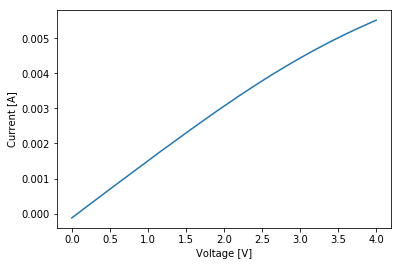

Calibration finished!

Turn on the laser pefore proceeding! Press any key to continue.l


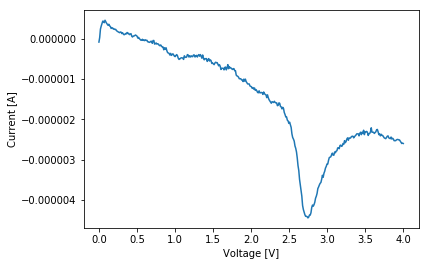

In [3]:
# Initialize objects
from Instruments.Keithley_2612B import Keithley_2612B
Q = MRM(Keithley_2612B(1, 26, 'b'))
Q.SMU.output_on()

# Set the voltage range + resolution
Q.V = np.linspace(0,4,400).tolist()

# Calibration
Q.calibrate()

# Find Initial value for power 
Q.sweep_norm()

In [6]:
# Running the feedback loop
FBL(Q, 250, 1, 100)

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-4.12, top=-4.12
  'bottom=%s, top=%s') % (bottom, top))
